In [2]:
# introducing new features

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

# Set PYTHONHASHSEED to prevent hash randomization
os.environ['PYTHONHASHSEED'] = '12345'

In [4]:
# import
# plotting inline
%matplotlib inline

# working directory
import sys
sys.path.append('../src')

# importing necessary modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import beta as beta_dist
from scipy.stats import norm as norm_dist
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm
from sklearn.linear_model import SGDClassifier, LogisticRegression
from scipy.optimize import minimize

import warnings
warnings.filterwarnings('ignore')

# turning off automatic plot showing, and setting style
plt.ioff()
plt.style.use('fivethirtyeight')

In [5]:
pd.set_option('display.max_rows', 1000)
import sys
sys.setrecursionlimit(10000)

In [6]:
from onlinelogisticregression import ( 
    ThompsonSamplingPolicy,
    GreedyPolicy,
    UCBPolicy,
    RandomPolicy,
)

In [111]:
experiment_params_name = [
"nArms",    "nPerRound",  "nRounds",    "nFeatures",    "lambda",   "alpha",    "nSims",    "seed"
]
experiment_params_nums = [
# [2,          100,         100,          2,              0.1,        1,          10,         66],
# [10,         100,         100,          2,              0.1,        1,          10,         66],
# [10,         100,         100,          3,              0.1,        1,          10,         66],
# [10,         100,         100,          3,              0.1,        10,          10,         66],
# [10,         10,         100,          3,              0.1,        10,          10,         66],
# [2,         10,         100,          2,              0.1,        10,          100,         66],
# [2,         10,         100,          2,              0.1,        10,          10,         66],
[2,         100,         100,          2,              0.1,        10,          10,         66],







]
experiment_params_df = pd.DataFrame(experiment_params_nums, columns=experiment_params_name)
experiment_params_df

nArms  nPerRound  nRounds  nFeatures  lambda  alpha  nSims  seed
0      2        100      100          2     0.1     10     10    66

In [112]:
experiment_params_df.dtypes

nArms          int64
nPerRound      int64
nRounds        int64
nFeatures      int64
lambda       float64
alpha          int64
nSims          int64
seed           int64
dtype: object

In [113]:
vl = (experiment_params_df.iloc[0,0])
type(vl)

numpy.int64

In [114]:
n_providers, n_data_point_per_round, n_rounds, n_dim, lambda_, alpha, n_sims, seed = experiment_params_df.iloc[0].values
type(seed)

numpy.float64

In [115]:
# # regret analysis
for param_index in range(len(experiment_params_nums)):
    n_providers, n_data_point_per_round, n_rounds, n_dim, lambda_, alpha, n_sims, seed = experiment_params_nums[param_index]
    print(f"Running simulation with {n_providers} arms, {n_data_point_per_round} data points per round, {n_rounds} rounds, {n_dim} features, lambda {lambda_}, alpha {alpha}, {n_sims} simulations")
    np.random.seed(seed)
    
    # do experiment
    experiment_df = pd.DataFrame()
    for simulation in range(n_sims):
        # instance of TS
        # params as dict:
        true_weights = np.random.uniform(-1, 1, n_dim)
        policy_params = {'lambda_': lambda_, 'alpha': alpha, 'n_dim': n_dim, 'true_weights': true_weights}

        ts_lr = ThompsonSamplingPolicy(**policy_params)
        exploit_lr = GreedyPolicy(**policy_params)
        ucb_lr = UCBPolicy(**policy_params)
        random_lr = RandomPolicy(**policy_params)

        dp_dict = {'ts_lr': ts_lr, 
                'exploit_lr': exploit_lr,
                'ucb_lr': ucb_lr,
                # 'random_lr': random_lr
                }
        
        for i in range(n_rounds):
            round_df = pd.DataFrame({'k': [], 'x': [], 'reward': [], 'regret': [],
                                    'true_weights': [], 'sample_weights': [], 
                                    'mean_weights': [], 'std_weights': [],
                                    'round': [],
                                    'simul_id': [],
                                    'policy': []})
                        # generate data
            X = np.random.uniform(-1, 1, (n_data_point_per_round, n_providers, n_dim))
            
            for key, online_lr in dp_dict.items():
                print(key)    
                scores = online_lr.calculate_score(X)
                best_arms = online_lr.get_best_arm(scores)
                best_arm_features = online_lr.get_best_features(best_arms, X)
                rewards, _ = online_lr.get_reward(best_arm_features)
                regrets = online_lr.calculate_regret(X, best_arm_features)

                # log the data
                temp_df = pd.DataFrame({'k': best_arms, 'x': list(best_arm_features),
                                        'reward': rewards, 'regret': regrets,
                                        'true_weights': [true_weights]*n_data_point_per_round,
                                        'sample_weights': [online_lr.w]*n_data_point_per_round,
                                        'mean_weights': [online_lr.m]*n_data_point_per_round,
                                        'std_weights': [online_lr.q]*n_data_point_per_round,
                                        'round':[i]*n_data_point_per_round}, 
                                        index=[i]*n_data_point_per_round)

                # fit the model
                online_lr.fit(best_arm_features, rewards)

                # append to round_df
                temp_df = temp_df.assign(simul_id = simulation, policy=key)

                round_df = pd.concat([round_df, temp_df])


            experiment_df = pd.concat([experiment_df, round_df])

    
    # save experiment_df to a file with the experiment parameters in the file name
    experiment_df.to_csv(f"../results/experiment_{n_providers}_{n_data_point_per_round}_{n_rounds}_{n_dim}_{lambda_}_{alpha}_{n_sims}_{seed}.csv", index=True)
    # also save it to a pickle file
    experiment_df.to_pickle(f"../results/experiment_{n_providers}_{n_data_point_per_round}_{n_rounds}_{n_dim}_{lambda_}_{alpha}_{n_sims}_{seed}.pkl")




Running simulation with 2 arms, 100 data points per round, 100 rounds, 2 features, lambda 0.1, alpha 10, 10 simulations
ts_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57684D+03    |proj g|=  1.85487D+01

At iterate    1    f=  1.20912D+03    |proj g|=  1.64486D+01

At iterate    2    f=  2.34497D+02    |proj g|=  8.61054D+00

At iterate    3    f=  1.12260D+02    |proj g|=  6.77026D+00

At iterate    4    f=  6.75603D+01    |proj g|=  1.92613D+00

At iterate    5    f=  6.63677D+01    |proj g|=  7.34803D-01

At iterate    6    f=  6.62758D+01    |proj g|=  3.87313D-01

At iterate    7    f=  6.62459D+01    |proj g|=  2.25599D-01

At iterate    8    f=  6.62355D+01    |proj g|=  6.48563D-02

At iterate    9    f=  6.62342D+01    |proj g|=  9.24346D-03

At iterate   10    f=  6.62342D+01    |proj g|=  4.24027D-04
exploit_lr

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    2    f=  5.26615D+01    |proj g|=  2.34712D-02

At iterate    3    f=  5.26615D+01    |proj g|=  2.18603D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.186D-07   5.266D+01
  F =   52.661461937773090     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.11598D+01    |proj g|=  2.66167D+01

At iterate    1    f=  5.58583D+01    |proj g|=  2.67230D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.48100D+01    |proj g|=  1.64288D+01

At iterate    1    f=  6.38908D+01    |proj g|=  1.43722D+00

At iterate    2    f=  6.38855D+01    |proj g|=  3.47469D-01
exploit_lr

At iterate    3    f=  6.38852D+01    |proj g|=  1.82430D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.824D-06   6.389D+01
  F =   63.885172282516443     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL          

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    2    f=  4.76225D+01    |proj g|=  4.96126D-03
ucb_lr

At iterate    3    f=  4.76225D+01    |proj g|=  2.92779D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.928D-09   4.762D+01
  F =   47.622468653309333     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.82751D+01    |proj g|=  4.84699D+00

At iterate    1    f=  4.82319D+01    |proj g|=  1.87398D-01



 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

ts_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.23074D+01    |proj g|=  1.56642D+01

At iterate    1    f=  5.18878D+01    |proj g|=  1.96271D+00

At iterate    2    f=  5.18800D+01    |proj g|=  3.90133D-01
exploit_lr

At iterate    3    f=  5.18797D+01    |proj g|=  4.76429D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   4.764D-06   5.188D+01
  F =   51.879681128798715     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.80973D+01    |proj g|=  1.51258D+00

At iterate    1    f=  5.80944D+01    |proj g|=  2.70883D-02
ucb_lr

At iterate    2    f=  5.80944D+01    |proj g|=  2.72111D-03

At iterate    3    f=  5.80944D+01    |proj g|=  2.14095D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.141D-10   5.809D+01
  F =   58.094376428989953     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
R

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    9    f=  6.74971D+01    |proj g|=  1.57927D-04

At iterate   10    f=  6.74971D+01    |proj g|=  7.53095D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     17      1     0     0   7.531D-06   6.750D+01
  F =   67.497059472562484     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ts_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28870D+02    |proj g|=  3.00397D+01

At iterate    1    f=  1.02245D+02    |proj g|=  2.30863D+01

A

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    1    f=  5.13562D+01    |proj g|=  2.36775D-02

At iterate    2    f=  5.13562D+01    |proj g|=  3.99173D-04

At iterate    3    f=  5.13562D+01    |proj g|=  3.96570D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   3.966D-09   5.136D+01
  F =   51.356244440435177     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ts_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.21321D+01    |proj g|=  1.53786D+01

A

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.652D-06   5.636D+01
  F =   56.358950477897217     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.99953D+01    |proj g|=  3.10593D+00

At iterate    1    f=  4.99662D+01    |proj g|=  1.81398D-01

At iterate    2    f=  4.99660D+01    |proj g|=  5.03704D-02
ucb_lr

At iterate    3    f=  4.99660D+01    |proj g|=  3.31440D-07



 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    1    f=  4.83567D+01    |proj g|=  2.23149D+00

At iterate    2    f=  4.83412D+01    |proj g|=  6.39833D-01

At iterate    3    f=  4.83398D+01    |proj g|=  3.30758D-05
exploit_lr

At iterate    4    f=  4.83398D+01    |proj g|=  2.35447D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      6      1     0     0   2.354D-09   4.834D+01
  F =   48.339768154692038     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the boun

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.67140D+01    |proj g|=  1.00630D+01
exploit_lr

At iterate    1    f=  4.63887D+01    |proj g|=  1.71986D+00

At iterate    2    f=  4.63782D+01    |proj g|=  2.38580D-01

At iterate    3    f=  4.63780D+01    |proj g|=  4.67468D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   4.675D-06   4.638D+01
  F =   46.378004003982021     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL          

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.29688D+01    |proj g|=  2.15458D+00

At iterate    1    f=  5.29554D+01    |proj g|=  3.98114D-01

At iterate    2    f=  5.29550D+01    |proj g|=  9.24758D-03
exploit_lr

At iterate    3    f=  5.29550D+01    |proj g|=  4.20109D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   4.201D-08   5.295D+01
  F =   52.954952033751695     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL          

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   5.072D-12   5.613D+01
  F =   56.129290179123231     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ts_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.40774D+01    |proj g|=  3.36041D+00

At iterate    1    f=  5.40605D+01    |proj g|=  3.84239D-01

At iterate    2    f=  5.40602D+01    |proj g|=  9.42125D-02
exploit_lr

At iterate    3    f=  5.40602D+01    |proj g|=  1.7

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.38976D+01    |proj g|=  5.84536D+00

At iterate    1    f=  5.38455D+01    |proj g|=  8.22229D-01

At iterate    2    f=  5.38443D+01    |proj g|=  1.62897D-01
exploit_lr

At iterate    3    f=  5.38442D+01    |proj g|=  5.93381D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   5.934D-07   5.384D+01
  F =   53.844209684230101     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL          

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.02672D+01    |proj g|=  7.63359D+00

At iterate    1    f=  5.95888D+01    |proj g|=  3.05235D-01

At iterate    2    f=  5.95879D+01    |proj g|=  7.68077D-02
exploit_lr

At iterate    3    f=  5.95879D+01    |proj g|=  1.28738D-05

At iterate    4    f=  5.95879D+01    |proj g|=  3.62728D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      6      1     0     0   3.627D-08   5.959D+01
  F =   59.587863445457060   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    1    f=  6.30707D+01    |proj g|=  1.55588D-01

At iterate    2    f=  6.30707D+01    |proj g|=  5.06515D-02

At iterate    3    f=  6.30706D+01    |proj g|=  1.78770D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.788D-07   6.307D+01
  F =   63.070649851903298     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.60145D+01    |proj g|=  9.13214D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

ucb_lr
At iterate    3    f=  5.90392D+01    |proj g|=  2.37922D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.379D-08   5.904D+01
  F =   59.039209088009059     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.06488D+01    |proj g|=  1.15834D+00

At iterate    1    f=  6.06455D+01    |proj g|=  9.37108D-02

At iterate    2    f=  6.06455D+01    |proj g|=  1.15067D-02



 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.02939D+01    |proj g|=  3.46492D-01

At iterate    1    f=  6.02936D+01    |proj g|=  4.00429D-02

At iterate    2    f=  6.02936D+01    |proj g|=  7.41897D-03
ucb_lr

At iterate    3    f=  6.02936D+01    |proj g|=  1.57424D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.574D-09   6.029D+01
  F =   60.293569541671246     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
R

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.57632D+01    |proj g|=  2.79743D+00

At iterate    1    f=  5.57512D+01    |proj g|=  2.01619D-01

At iterate    2    f=  5.57511D+01    |proj g|=  4.39567D-02

At iterate    3    f=  5.57511D+01    |proj g|=  2.54340D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.543D-08   5.575D+01
  F =   55.751100732027652     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ts_lr
RU

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10
exploit_lr

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.33436D+01    |proj g|=  5.30714D+00

At iterate    1    f=  6.32995D+01    |proj g|=  2.24157D-01

At iterate    2    f=  6.32994D+01    |proj g|=  8.60337D-02

At iterate    3    f=  6.32994D+01    |proj g|=  1.26821D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.268D-08   6.330D+01
  F =   63.299418783397279     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL          

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    1    f=  6.68220D+01    |proj g|=  4.35945D-01

At iterate    2    f=  6.68217D+01    |proj g|=  1.21780D-01
exploit_lr

At iterate    3    f=  6.68217D+01    |proj g|=  1.34039D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.340D-07   6.682D+01
  F =   66.821721565995261     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.09266D+01    |proj g|=  2.19947D+

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

ts_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.12335D+01    |proj g|=  1.20915D+01

At iterate    1    f=  7.20801D+01    |proj g|=  4.60231D+00

At iterate    2    f=  7.01553D+01    |proj g|=  5.93106D-01

At iterate    3    f=  7.01209D+01    |proj g|=  3.88739D-02

At iterate    4    f=  7.01207D+01    |proj g|=  5.57569D-04
exploit_lr

At iterate    5    f=  7.01207D+01    |proj g|=  5.69671D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      6     

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    1    f=  6.42265D+01    |proj g|=  4.43707D-02

At iterate    2    f=  6.42265D+01    |proj g|=  4.90317D-03
ucb_lr

At iterate    3    f=  6.42265D+01    |proj g|=  1.24411D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.244D-08   6.423D+01
  F =   64.226537310118459     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.00759D+01    |proj g|=  5.05909D+00



 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    0    f=  6.69546D+01    |proj g|=  1.22871D+01

At iterate    1    f=  6.64041D+01    |proj g|=  8.83392D-01

At iterate    2    f=  6.64009D+01    |proj g|=  1.30499D-01

At iterate    3    f=  6.64008D+01    |proj g|=  2.33959D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.340D-06   6.640D+01
  F =   66.400797749152005     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
exploit_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the boun

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10
ucb_lr

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.98332D+01    |proj g|=  1.28256D+00

At iterate    1    f=  5.98298D+01    |proj g|=  7.00394D-03

At iterate    2    f=  5.98298D+01    |proj g|=  1.39307D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      4      1     0     0   1.393D-03   5.983D+01
  F =   59.829787512333994     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    1    f=  5.97584D+01    |proj g|=  9.07566D-02

At iterate    2    f=  5.97584D+01    |proj g|=  1.48074D-02
ucb_lr

At iterate    3    f=  5.97584D+01    |proj g|=  6.03250D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   6.033D-09   5.976D+01
  F =   59.758432921295515     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.64622D+01    |proj g|=  3.74689D+00



 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.25867D+01    |proj g|=  1.28780D+01

At iterate    1    f=  6.22489D+01    |proj g|=  1.32994D+00
exploit_lr

At iterate    2    f=  6.22456D+01    |proj g|=  9.61919D-02

At iterate    3    f=  6.22456D+01    |proj g|=  3.51438D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   3.514D-07   6.225D+01
  F =   62.245582227450541     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL          

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    2    f=  5.94442D+01    |proj g|=  5.27683D-03

At iterate    3    f=  5.94442D+01    |proj g|=  1.92408D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.924D-10   5.944D+01
  F =   59.444194027266732     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ts_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.99002D+01    |proj g|=  6.67288D+00
exploit_lr

At iterate    1    f=  5.98477D+01    |proj g|=  3.9

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.23752D+01    |proj g|=  1.03537D+01

At iterate    1    f=  6.22683D+01    |proj g|=  6.26195D-01

At iterate    2    f=  6.22678D+01    |proj g|=  1.13938D-01
exploit_lr

At iterate    3    f=  6.22678D+01    |proj g|=  1.46888D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.469D-07   6.227D+01
  F =   62.267822668481486     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL          

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    1    f=  5.55469D+01    |proj g|=  4.99120D+00

At iterate    2    f=  5.49112D+01    |proj g|=  2.31688D+00

At iterate    3    f=  5.48259D+01    |proj g|=  4.15776D-01

At iterate    4    f=  5.48226D+01    |proj g|=  9.26674D-04

At iterate    5    f=  5.48226D+01    |proj g|=  9.09631D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      6      1     0     0   9.096D-06   5.482D+01
  F =   54.822643765078567     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    4    f=  5.38883D+01    |proj g|=  4.63251D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      6      1     0     0   4.633D-09   5.389D+01
  F =   53.888295777141458     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.66832D+01    |proj g|=  2.85389D+00
ucb_lr

At iterate    1    f=  5.66513D+01    |proj g|=  5.35972D-02

At iterate    2    f=  5.66513D+01    |proj g|=  8.06397D-03



 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

ucb_lr
At iterate    0    f=  5.76757D+01    |proj g|=  7.20858D-01

At iterate    1    f=  5.76738D+01    |proj g|=  4.84348D-02

At iterate    2    f=  5.76738D+01    |proj g|=  2.91373D-03

At iterate    3    f=  5.76738D+01    |proj g|=  1.11661D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.117D-09   5.767D+01
  F =   57.673768950989555     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds



 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    1    f=  5.46688D+01    |proj g|=  1.96903D+00

At iterate    2    f=  5.46541D+01    |proj g|=  7.39976D-01

At iterate    3    f=  5.46517D+01    |proj g|=  3.50481D-05
exploit_lr

At iterate    4    f=  5.46517D+01    |proj g|=  7.03469D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      6      1     0     0   7.035D-10   5.465D+01
  F =   54.651654341615597     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ucb_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at t

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    2    f=  5.72318D+01    |proj g|=  5.41665D-01
exploit_lr

At iterate    3    f=  5.72311D+01    |proj g|=  6.72391D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   6.724D-06   5.723D+01
  F =   57.231082567180501     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.86936D+01    |proj g|=  1.48583D+00

At iterate    1    f=  5.86905D+01    |proj g|=  1.04674D-

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.21059D+01    |proj g|=  1.41762D+01

At iterate    1    f=  5.16861D+01    |proj g|=  2.62156D+00

At iterate    2    f=  5.16678D+01    |proj g|=  8.43956D-01

At iterate    3    f=  5.16657D+01    |proj g|=  3.06745D-05

At iterate    4    f=  5.16657D+01    |proj g|=  3.56892D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      6      1     0     0   3.569D-10   5.167D+01
  F =   51.665686999203643     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.83729D+01    |proj g|=  1.72725D+01

At iterate    1    f=  5.79918D+01    |proj g|=  1.25448D-01

At iterate    2    f=  5.79917D+01    |proj g|=  5.17898D-02

At iterate    3    f=  5.79917D+01    |proj g|=  4.78126D-08
exploit_lr

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   4.781D-08   5.799D+01
  F =   57.991727145020768     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL          

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.32228D+01    |proj g|=  2.26334D+00

At iterate    1    f=  5.32163D+01    |proj g|=  2.78355D-01

At iterate    2    f=  5.32161D+01    |proj g|=  1.05859D-01
exploit_lr

At iterate    3    f=  5.32161D+01    |proj g|=  1.75203D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.752D-07   5.322D+01
  F =   53.216123794679710     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL          

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    2    f=  6.46354D+01    |proj g|=  7.23634D-04

At iterate    3    f=  6.46354D+01    |proj g|=  7.30349D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   7.303D-06   6.464D+01
  F =   64.635425504378915     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ts_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.54085D+01    |proj g|=  2.41017D+01

At iterate    1    f=  5.51685D+01    |proj g|=  3.37868D+00

A

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    1    f=  5.15241D+01    |proj g|=  1.27640D-01

At iterate    2    f=  5.15240D+01    |proj g|=  3.12262D-02
exploit_lr

At iterate    3    f=  5.15239D+01    |proj g|=  3.07018D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   3.070D-07   5.152D+01
  F =   51.523949809860611     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.69163D+01    |proj g|=  2.20688D+

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.60606D+01    |proj g|=  9.87251D+00

At iterate    1    f=  5.56361D+01    |proj g|=  9.02125D-01
exploit_lr

At iterate    2    f=  5.56333D+01    |proj g|=  2.01027D-01

At iterate    3    f=  5.56332D+01    |proj g|=  3.09214D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   3.092D-06   5.563D+01
  F =   55.633153509381664     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL          

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.04920D+01    |proj g|=  1.54672D+00

At iterate    1    f=  6.04879D+01    |proj g|=  5.07937D-02

At iterate    2    f=  6.04879D+01    |proj g|=  4.70322D-03

At iterate    3    f=  6.04879D+01    |proj g|=  1.56429D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.564D-09   6.049D+01
  F =   60.487879151364815     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ts_lr
RU

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

ts_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.76152D+01    |proj g|=  8.09776D+00
exploit_lr

At iterate    1    f=  5.74644D+01    |proj g|=  7.33937D-01

At iterate    2    f=  5.74630D+01    |proj g|=  1.16661D-01

At iterate    3    f=  5.74629D+01    |proj g|=  6.43199D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   6.432D-07   5.746D+01
  F =   57.462937008938617     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    1    f=  5.21052D+01    |proj g|=  2.12099D+00
exploit_lr

At iterate    2    f=  5.20929D+01    |proj g|=  1.56998D-01

At iterate    3    f=  5.20929D+01    |proj g|=  2.58866D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.589D-06   5.209D+01
  F =   52.092865054803809     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.40757D+01    |proj g|=  1.32571D+

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    3    f=  6.04273D+01    |proj g|=  4.75499D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   4.755D-07   6.043D+01
  F =   60.427295798720003     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.19106D+01    |proj g|=  3.74420D+00

At iterate    1    f=  5.18918D+01    |proj g|=  1.86540D-01

At iterate    2    f=  5.18917D+01    |proj g|=  2.01821D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    2    f=  5.51477D+01    |proj g|=  8.10794D-04

At iterate    3    f=  5.51477D+01    |proj g|=  2.10444D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.104D-10   5.515D+01
  F =   55.147666218704693     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ts_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.58705D+01    |proj g|=  1.37655D+01

At iterate    1    f=  5.55976D+01    |proj g|=  8.76509D-01
ex

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

ts_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.12324D+01    |proj g|=  1.19715D+01
exploit_lr

At iterate    1    f=  6.39747D+01    |proj g|=  8.99464D-01

At iterate    2    f=  6.39342D+01    |proj g|=  1.60719D-02

At iterate    3    f=  6.39342D+01    |proj g|=  2.00594D-04

At iterate    4    f=  6.39342D+01    |proj g|=  3.09670D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      5      1     0     0   3.097D-05   6.393D+01
  F =   63.934181473732

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10
exploit_lr

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.42682D+01    |proj g|=  1.57933D+01

At iterate    1    f=  6.23833D+01    |proj g|=  1.06292D+00

At iterate    2    f=  6.23757D+01    |proj g|=  1.13077D-01

At iterate    3    f=  6.23756D+01    |proj g|=  5.31862D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   5.319D-06   6.238D+01
  F =   62.375576495887586     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL          

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.06620D+01    |proj g|=  2.01248D+01

At iterate    1    f=  5.92929D+01    |proj g|=  4.52370D-01

At iterate    2    f=  5.92920D+01    |proj g|=  8.59843D-02
exploit_lr

At iterate    3    f=  5.92920D+01    |proj g|=  1.12983D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.130D-06   5.929D+01
  F =   59.291999365711305     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL          

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.24400D+01    |proj g|=  7.76697D+00

At iterate    1    f=  6.22576D+01    |proj g|=  2.45794D-01

At iterate    2    f=  6.22574D+01    |proj g|=  6.50549D-02
exploit_lr

At iterate    3    f=  6.22574D+01    |proj g|=  1.16469D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.165D-07   6.226D+01
  F =   62.257417151148822     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL          

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.04577D+01    |proj g|=  1.04880D+01

At iterate    1    f=  6.00375D+01    |proj g|=  1.39439D+00

At iterate    2    f=  6.00301D+01    |proj g|=  1.59535D-02
exploit_lr

At iterate    3    f=  6.00301D+01    |proj g|=  2.80160D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.802D-07   6.003D+01
  F =   60.030096560442757     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL          

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    1    f=  6.02703D+01    |proj g|=  9.70571D-02

At iterate    2    f=  6.02702D+01    |proj g|=  1.61656D-02

At iterate    3    f=  6.02702D+01    |proj g|=  9.14427D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   9.144D-09   6.027D+01
  F =   60.270244249873713     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ts_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.29890D+01    |proj g|=  3.97194D+00

A

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.66671D+01    |proj g|=  2.13144D+00

At iterate    1    f=  5.66613D+01    |proj g|=  8.03360D-02
ucb_lr

At iterate    2    f=  5.66613D+01    |proj g|=  2.03151D-02

At iterate    3    f=  5.66613D+01    |proj g|=  8.63741D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   8.637D-09   5.666D+01
  F =   56.661326213033121     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
R

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    1    f=  5.67932D+01    |proj g|=  1.30278D-01

At iterate    2    f=  5.67932D+01    |proj g|=  3.48556D-02

At iterate    3    f=  5.67932D+01    |proj g|=  2.10547D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.105D-08   5.679D+01
  F =   56.793170370221084     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ts_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.57745D+01    |proj g|=  1.43399D+01

A

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

ts_lr
exploit_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.94800D+01    |proj g|=  9.42551D+00

At iterate    1    f=  5.93450D+01    |proj g|=  1.35245D+00

At iterate    2    f=  5.93428D+01    |proj g|=  2.38749D-01

At iterate    3    f=  5.93427D+01    |proj g|=  4.07541D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   4.075D-07   5.934D+01
  F =   59.342681575805258     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75739D+01    |proj g|=  9.42593D+00

At iterate    1    f=  6.55922D+01    |proj g|=  8.02369D-01
exploit_lr

At iterate    2    f=  6.55810D+01    |proj g|=  1.82167D-01

At iterate    3    f=  6.55804D+01    |proj g|=  6.51788D-05

At iterate    4    f=  6.55804D+01    |proj g|=  9.21280D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      6      1     0     0   9.213D-08   6.558D+01
  F =   65.580374802973154   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.66570D+01    |proj g|=  1.46891D+01

At iterate    1    f=  6.50118D+01    |proj g|=  1.28516D+00

At iterate    2    f=  6.50014D+01    |proj g|=  2.32440D-01
exploit_lr

At iterate    3    f=  6.50011D+01    |proj g|=  1.33378D-05

At iterate    4    f=  6.50011D+01    |proj g|=  7.15122D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      6      1     0     0   7.151D-09   6.500D+01
  F =   65.001082831165078   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.07144D+01    |proj g|=  1.54287D+01

At iterate    1    f=  6.93227D+01    |proj g|=  2.04220D+00
exploit_lr

At iterate    2    f=  6.92971D+01    |proj g|=  1.50215D-01

At iterate    3    f=  6.92970D+01    |proj g|=  7.33272D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   7.333D-06   6.930D+01
  F =   69.297004479997369     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL          

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.60718D+01    |proj g|=  6.39046D+00
exploit_lr

At iterate    1    f=  6.59556D+01    |proj g|=  3.69368D-01

At iterate    2    f=  6.59553D+01    |proj g|=  1.04570D-01

At iterate    3    f=  6.59553D+01    |proj g|=  4.64813D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   4.648D-08   6.596D+01
  F =   65.955309020292518     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL          

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    1    f=  5.22812D+01    |proj g|=  1.54459D-02
ucb_lr

At iterate    2    f=  5.22812D+01    |proj g|=  3.15942D-03

At iterate    3    f=  5.22812D+01    |proj g|=  1.42837D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.428D-09   5.228D+01
  F =   52.281245670580333     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.32828D+01    |proj g|=  2.01994D+00



 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.37503D+01    |proj g|=  1.31265D+01
exploit_lr

At iterate    1    f=  6.34415D+01    |proj g|=  5.89162D-01

At iterate    2    f=  6.34411D+01    |proj g|=  1.59506D-01

At iterate    3    f=  6.34410D+01    |proj g|=  9.40585D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   9.406D-08   6.344D+01
  F =   63.441033871681256     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL          

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

ts_lr
exploit_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.44294D+01    |proj g|=  3.67977D+00

At iterate    1    f=  6.44076D+01    |proj g|=  3.61186D-01

At iterate    2    f=  6.44073D+01    |proj g|=  4.77017D-02

At iterate    3    f=  6.44073D+01    |proj g|=  6.98464D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   6.985D-08   6.441D+01
  F =   64.407339106103578     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.16202D+01    |proj g|=  1.51351D+00

At iterate    1    f=  5.16167D+01    |proj g|=  1.40087D-01

At iterate    2    f=  5.16167D+01    |proj g|=  1.63001D-02

At iterate    3    f=  5.16167D+01    |proj g|=  5.85553D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   5.856D-09   5.162D+01
  F =   51.616710506440768     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ts_lr
RU

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    1    f=  6.95502D+01    |proj g|=  3.61425D-01

At iterate    2    f=  6.95501D+01    |proj g|=  7.43006D-02

At iterate    3    f=  6.95500D+01    |proj g|=  5.12887D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   5.129D-08   6.955D+01
  F =   69.550043975336550     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.98627D+01    |proj g|=  1.90845D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    1    f=  1.04006D+03    |proj g|=  1.24359D+01

At iterate    2    f=  1.89524D+02    |proj g|=  6.63030D+00

At iterate    3    f=  1.02434D+02    |proj g|=  6.78026D+00

At iterate    4    f=  7.65422D+01    |proj g|=  5.28746D+00

At iterate    5    f=  6.74133D+01    |proj g|=  3.39408D+00

At iterate    6    f=  6.41142D+01    |proj g|=  4.33833D-01

At iterate    7    f=  6.41040D+01    |proj g|=  2.75898D-01
exploit_lr

At iterate    8    f=  6.40873D+01    |proj g|=  2.30059D-01

At iterate    9    f=  6.40824D+01    |proj g|=  8.96888D-02

At iterate   10    f=  6.40808D+01    |proj g|=  6.69482D-03

At iterate   11    f=  6.40808D+01    |proj g|=  8.31154D-04

At iterate   12    f=  6.40808D+01    |proj g|=  1.08704D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final g

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    2    f=  6.37476D+01    |proj g|=  1.90541D-02
exploit_lr

At iterate    3    f=  6.37476D+01    |proj g|=  4.79039D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   4.790D-07   6.375D+01
  F =   63.747590584640932     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.43718D+01    |proj g|=  2.93595D+00

At iterate    1    f=  6.43001D+01    |proj g|=  2.08838D-

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ts_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.30639D+01    |proj g|=  9.46269D+00

At iterate    1    f=  6.27268D+01    |proj g|=  4.92018D-01

At iterate    2    f=  6.27258D+01    |proj g|=  7.10543D-02

At iterate    3    f=  6.27258D+01    |proj g|=  8.48334D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
exploit_lr
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   8.483D-07   6.273D+01
  F =   62.725776125752070     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

ts_lr
exploit_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.09175D+01    |proj g|=  8.55395D+00

At iterate    1    f=  6.07065D+01    |proj g|=  3.35205D-01

At iterate    2    f=  6.07062D+01    |proj g|=  5.73047D-02

At iterate    3    f=  6.07062D+01    |proj g|=  1.46993D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.470D-07   6.071D+01
  F =   60.706181958272282     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

ts_lr
exploit_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.95267D+01    |proj g|=  8.88829D+00

At iterate    1    f=  5.92251D+01    |proj g|=  7.21343D-01

At iterate    2    f=  5.92231D+01    |proj g|=  7.48441D-03

At iterate    3    f=  5.92231D+01    |proj g|=  1.06269D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.063D-07   5.922D+01
  F =   59.223122269429894     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ts_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.00370D+01    |proj g|=  7.00419D+00
exploit_lr

At iterate    1    f=  5.99434D+01    |proj g|=  4.68488D-01

At iterate    2    f=  5.99430D+01    |proj g|=  4.77507D-02

At iterate    3    f=  5.99430D+01    |proj g|=  1.94436D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.944D-07   5.994D+01
  F =   59.942968561974759     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr


At iterate    3    f=  5.55337D+01    |proj g|=  3.56515D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   3.565D-10   5.553D+01
  F =   55.533652660538031     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.67930D+01    |proj g|=  2.32951D+00

At iterate    1    f=  5.67860D+01    |proj g|=  6.95729D-03

At iterate    2    f=  5.67860D+01    |proj g|=  2.89695D-05

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.85838D+01    |proj g|=  1.39058D+00
ucb_lr

At iterate    1    f=  5.85811D+01    |proj g|=  2.93234D-02

At iterate    2    f=  5.85811D+01    |proj g|=  1.04544D-03

At iterate    3    f=  5.85811D+01    |proj g|=  6.32336D-11

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   6.323D-11   5.858D+01
  F =   58.581058701425995     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
R

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This pr

ts_lr
exploit_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.69301D+01    |proj g|=  1.56159D+01

At iterate    1    f=  5.66449D+01    |proj g|=  6.83255D-01

At iterate    2    f=  5.66444D+01    |proj g|=  1.37751D-01

At iterate    3    f=  5.66444D+01    |proj g|=  1.13006D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.130D-07   5.664D+01
  F =   56.644399788273958     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ts_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.98562D+01    |proj g|=  1.50797D+01

At iterate    1    f=  5.95910D+01    |proj g|=  1.30543D+00
exploit_lr

At iterate    2    f=  5.95888D+01    |proj g|=  1.45938D-01

At iterate    3    f=  5.95888D+01    |proj g|=  5.72803D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   5.728D-07   5.959D+01
  F =   59.588806068045571     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    3    f=  6.48623D+01    |proj g|=  1.79069D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.791D-09   6.486D+01
  F =   64.862263903721527     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ts_lr
exploit_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.31750D+01    |proj g|=  1.62167D+01

At iterate    1    f=  6.49707D+01    |proj g|=  1.79515D+00

At iterate    2    f=  6.47915D+01    |proj g|=  4.4

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.63777D+01    |proj g|=  1.14160D+01

At iterate    1    f=  6.54758D+01    |proj g|=  3.82829D-01

At iterate    2    f=  6.54746D+01    |proj g|=  6.76458D-02
exploit_lr

At iterate    3    f=  6.54746D+01    |proj g|=  2.64327D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   2.643D-06   6.547D+01
  F =   65.474577584181858     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL          

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    1    f=  5.32949D+01    |proj g|=  4.47883D-01

At iterate    2    f=  5.32940D+01    |proj g|=  5.62741D-02

At iterate    3    f=  5.32940D+01    |proj g|=  9.04447D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   9.044D-07   5.329D+01
  F =   53.293981533579355     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.09242D+01    |proj g|=  6.17405D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ts_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10
exploit_lr

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.97129D+01    |proj g|=  1.20947D+01

At iterate    1    f=  5.90702D+01    |proj g|=  9.21239D-01

At iterate    2    f=  5.90667D+01    |proj g|=  4.91943D-02

At iterate    3    f=  5.90667D+01    |proj g|=  3.36730D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   3.367D-07   5.907D+01
  F =   59.066720908701008     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    1    f=  5.80434D+01    |proj g|=  1.58395D-01

At iterate    2    f=  5.80434D+01    |proj g|=  2.07992D-02

At iterate    3    f=  5.80434D+01    |proj g|=  1.10430D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.104D-07   5.804D+01
  F =   58.043383077322638     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.46866D+01    |proj g|=  2.12120D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.64956D+01    |proj g|=  1.79208D+01
exploit_lr

At iterate    1    f=  5.59448D+01    |proj g|=  1.50828D-01

At iterate    2    f=  5.59447D+01    |proj g|=  1.43746D-02

At iterate    3    f=  5.59447D+01    |proj g|=  1.14529D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.145D-08   5.594D+01
  F =   55.944712683750794     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL          

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    1    f=  5.60687D+01    |proj g|=  6.42675D-01

At iterate    2    f=  5.60679D+01    |proj g|=  3.54319D-02
exploit_lr

At iterate    3    f=  5.60679D+01    |proj g|=  8.73972D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   8.740D-08   5.607D+01
  F =   56.067927400363587     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.99486D+01    |proj g|=  3.08748D+

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    2    f=  5.36898D+01    |proj g|=  4.32628D-02

At iterate    3    f=  5.36898D+01    |proj g|=  1.98083D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.981D-08   5.369D+01
  F =   53.689836960172727     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ts_lr
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.69136D+01    |proj g|=  1.78076D+00
exploit_lr

At iterate    1    f=  5.69060D+01    |proj g|=  7.4

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    1    f=  5.29644D+01    |proj g|=  4.11849D-02

At iterate    2    f=  5.29644D+01    |proj g|=  2.66407D-03
exploit_lr

At iterate    3    f=  5.29644D+01    |proj g|=  1.12324D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.123D-09   5.296D+01
  F =   52.964369097792975     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.43808D+01    |proj g|=  3.09850D+

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.17149D+01    |proj g|=  2.15429D+00

At iterate    1    f=  5.17090D+01    |proj g|=  2.48388D-01

At iterate    2    f=  5.17089D+01    |proj g|=  4.11321D-02

At iterate    3    f=  5.17089D+01    |proj g|=  5.42478D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   5.425D-08   5.171D+01
  F =   51.708880059180494     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ts_lr
RU

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.30216D+01    |proj g|=  3.18076D+01
exploit_lr

At iterate    1    f=  6.20418D+01    |proj g|=  9.55368D-02

At iterate    2    f=  6.20418D+01    |proj g|=  3.86689D-03

At iterate    3    f=  6.20418D+01    |proj g|=  7.47621D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   7.476D-09   6.204D+01
  F =   62.041766585512448     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL          

In [116]:
# analysis with the results
# load the results from pickle
n_providers, n_data_point_per_round, n_rounds, n_dim, lambda_, alpha, n_sims, seed = experiment_params_nums[0]
print(f"Analyzing simulation with {n_providers} arms, {n_data_point_per_round} data points per round, {n_rounds} rounds, {n_dim} features, lambda {lambda_}, alpha {alpha}, {n_sims} simulations")
experiment_df = pd.read_pickle(f"../results/experiment_{n_providers}_{n_data_point_per_round}_{n_rounds}_{n_dim}_{lambda_}_{alpha}_{n_sims}_{seed}.pkl")


Analyzing simulation with 2 arms, 100 data points per round, 100 rounds, 2 features, lambda 0.1, alpha 10, 10 simulations


In [117]:
experiment_df_10 = experiment_df[experiment_df['simul_id'] == 0]
experiment_df_10.head(10)

k                                           x  reward    regret  \
0  0.0   [-0.8256479927820837, 0.6581908845554907]     0.0  0.201990   
0  0.0     [0.356011513266024, 0.8069780659364101]     0.0  0.178596   
0  0.0    [0.3286550326818134, 0.2681135105349426]     0.0  0.314540   
0  0.0   [-0.6694203209052805, 0.7586379827700906]     0.0  0.210929   
0  0.0  [-0.7689988272279416, -0.8074117146324487]     1.0  0.010510   
0  0.0   [-0.9554883088503536, 0.5420854435643991]     0.0  0.096971   
0  0.0   [0.8824661266579981, -0.5669753936989694]     0.0  0.255054   
0  1.0  [-0.7476807350144461, -0.1715663320529035]     1.0  0.018953   
0  1.0   [0.9140801815888582, -0.7473683760226957]     0.0  0.036483   
0  1.0   [0.9095358018798885, -0.4638774884391512]     0.0  0.316907   

                                 true_weights  \
0  [-0.6914248437374484, -0.7326008785998681]   
0  [-0.6914248437374484, -0.7326008785998681]   
0  [-0.6914248437374484, -0.7326008785998681]   
0  [-0.6914248437374484, -0.7326008785998681]   
0  [-0.6914248437374484, -0.7326008785998681]   
0  [-0.6914248437374484, -0.7326008785998681]   
0  [-0.6914248437374484, -0.7326008785998681]   
0  [-0.6914248437374484, -0.7326008785998681]   
0  [-0.6914248437374484, -0.7326008785998681]   
0  [-0.6914248437374484, -0.7326008785998681]   

                             sample_weights mean_weights std_weights  round  \
0  [-6.358715258228031, 124.15947228072449]   [0.0, 0.0]  [0.1, 0.1]    0.0   
0  [-6.358715258228031, 124.15947228072449]   [0.0, 0.0]  [0.1, 0.1]    0.0   
0  [-6.358715258228031, 124.15947228072449]   [0.0, 0.0]  [0.1, 0.1]    0.0   
0  [-6.358715258228031, 124.15947228072449]   [0.0, 0.0]  [0.1, 0.1]    0.0   
0  [-6.358715258228031, 124.15947228072449]   [0.0, 0.0]  [0.1, 0.1]    0.0   
0  [-6.358715258228031, 124.15947228072449]   [0.0, 0.0]  [0.1, 0.1]    0.0   
0  [-6.358715258228031, 124.15947228072449]   [0.0, 0.0]  [0.1, 0.1]    0.0   
0  [-6.358715258228031, 124.15947228072449]   [0.0, 0.0]  [0.1, 0.1]    0.0   
0  [-6.358715258228031, 124.15947228072449]   [0.0, 0.0]  [0.1, 0.1]    0.0   
0  [-6.358715258228031, 124.15947228072449]   [0.0, 0.0]  [0.1, 0.1]    0.0   

   simul_id policy  
0       0.0  ts_lr  
0       0.0  ts_lr  
0       0.0  ts_lr  
0       0.0  ts_lr  
0       0.0  ts_lr  
0       0.0  ts_lr  
0       0.0  ts_lr  
0       0.0  ts_lr  
0       0.0  ts_lr  
0       0.0  ts_lr

In [118]:
experiment_df_10.groupby(['round', 'policy']).agg({'reward': 'sum', 
                                                   'regret': ['count','sum'],
                                                   'true_weights':'first',
                                                   'sample_weights':'first',
                                                   'mean_weights':'first',
                                                   'std_weights':'first'}).head(10)

reward regret             \
                    sum  count        sum   
round policy                                
0.0   exploit_lr   44.0    100   8.580371   
      ts_lr        39.0    100  12.716504   
      ucb_lr       55.0    100   6.795096   
1.0   exploit_lr   56.0    100   0.107550   
      ts_lr        48.0    100  14.054360   
      ucb_lr       49.0    100   4.314442   
2.0   exploit_lr   54.0    100   0.003557   
      ts_lr        51.0    100   5.446688   
      ucb_lr       62.0    100   3.319091   
3.0   exploit_lr   65.0    100   0.000000   

                                                true_weights  \
                                                       first   
round policy                                                   
0.0   exploit_lr  [-0.6914248437374484, -0.7326008785998681]   
      ts_lr       [-0.6914248437374484, -0.7326008785998681]   
      ucb_lr      [-0.6914248437374484, -0.7326008785998681]   
1.0   exploit_lr  [-0.6914248437374484, -0.7326008785998681]   
      ts_lr       [-0.6914248437374484, -0.7326008785998681]   
      ucb_lr      [-0.6914248437374484, -0.7326008785998681]   
2.0   exploit_lr  [-0.6914248437374484, -0.7326008785998681]   
      ts_lr       [-0.6914248437374484, -0.7326008785998681]   
      ucb_lr      [-0.6914248437374484, -0.7326008785998681]   
3.0   exploit_lr  [-0.6914248437374484, -0.7326008785998681]   

                                               sample_weights  \
                                                        first   
round policy                                                    
0.0   exploit_lr                                   [0.0, 0.0]   
      ts_lr          [-6.358715258228031, 124.15947228072449]   
      ucb_lr         [34.704772990053776, 155.64911035260465]   
1.0   exploit_lr   [-0.5533930707282978, -1.1966236085646398]   
      ts_lr           [0.857822341125013, 3.6685690156989272]   
      ucb_lr       [-0.8886292591961423, -0.5108858581124323]   
2.0   exploit_lr   [-1.1412805999512299, -1.3537730056057848]   
      ts_lr           [-1.35964355491174, 0.6544533070866119]   
      ucb_lr      [-1.1587510310898286, -0.46992729632329344]   
3.0   exploit_lr   [-1.3825321184061654, -1.3509221311744104]   

                                                 mean_weights  \
                                                        first   
round policy                                                    
0.0   exploit_lr                                   [0.0, 0.0]   
      ts_lr                                        [0.0, 0.0]   
      ucb_lr                                       [0.0, 0.0]   
1.0   exploit_lr   [-0.5533930707282978, -1.1966236085646398]   
      ts_lr          [-1.144798180936491, 0.7124063204716655]   
      ucb_lr       [-0.8886292591961423, -0.5108858581124323]   
2.0   exploit_lr   [-1.1412805999512299, -1.3537730056057848]   
      ts_lr         [-0.8197007388917108, 0.8903380482132001]   
      ucb_lr      [-1.1587510310898286, -0.46992729632329344]   
3.0   exploit_lr   [-1.3825321184061654, -1.3509221311744104]   

                                               std_weights  
                                                     first  
round policy                                                
0.0   exploit_lr                                [0.1, 0.1]  
      ts_lr                                     [0.1, 0.1]  
      ucb_lr                                    [0.1, 0.1]  
1.0   exploit_lr    [7.231747474483748, 7.097599014699681]  
      ts_lr         [6.470875616279733, 6.972962078725421]  
      ucb_lr        [10.40891965771233, 9.931342058912113]  
2.0   exploit_lr   [13.406045301120127, 13.11358197721415]  
      ts_lr       [13.328685175013582, 14.224952324751088]  
      ucb_lr        [19.02815551125171, 20.22231968180077]  
3.0   exploit_lr   [19.12208982461321, 19.935473923420894]

In [141]:
def plot_regret(regret_df, n_sims, regret_type='instant'):
    # closing all past figures
    plt.close('all')

    # opening figure to plot regret
    plt.figure(figsize=(10, 3), dpi=150)

    # loop for each decision policy
    for policy in dp_dict.keys():
        
        if regret_type == 'instant':
            plt.plot(regret_df.loc[policy,:].values, label=policy, linewidth=1.5)
        elif regret_type == 'cumulative':
            plt.plot(np.cumsum(regret_df.loc[policy,:].values), label=policy, linewidth=1.5)
        else:
            raise ValueError('regret_type must be either instant or cumulative')
        
    # adding title
    plt.title('Comparison of cumulative regret for each method in {} simulation'.format(n_sims), fontsize=10)

    # adding legend
    plt.legend(fontsize=8); plt.xticks(fontsize=10); plt.yticks(fontsize=10)

    # showing plot
    plt.show()

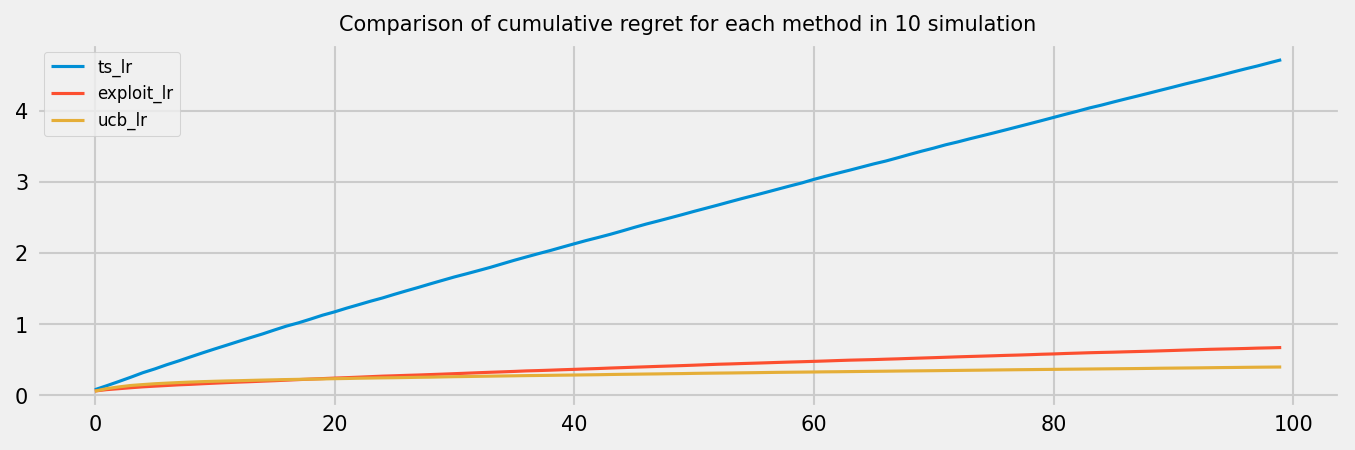

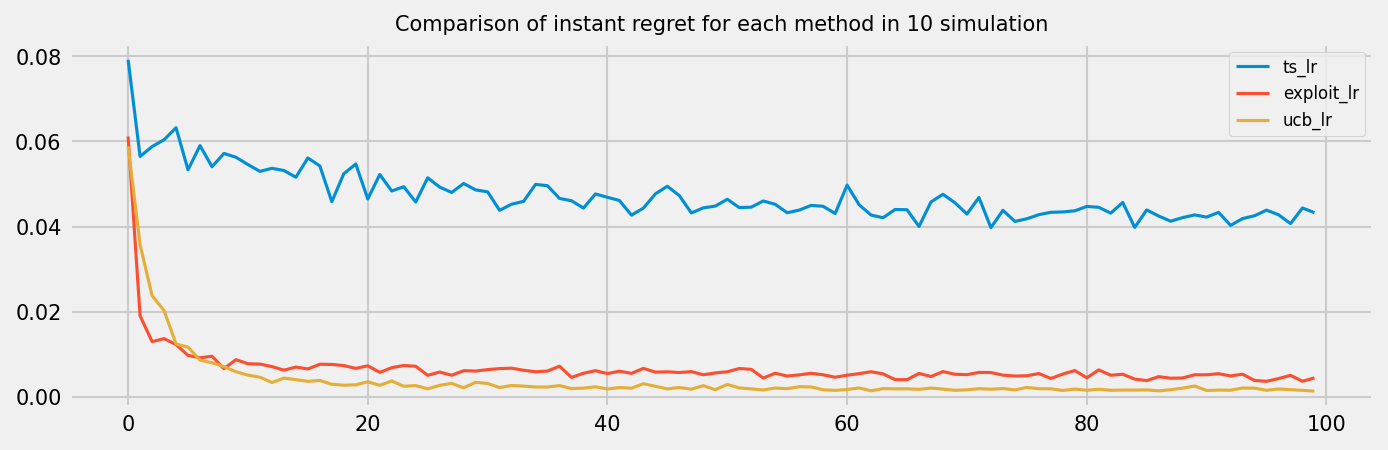

In [120]:
# instant

In [121]:
# plot final weights

In [122]:
print(ts_lr.w, ts_lr.m, ts_lr.q)
print(exploit_lr.w, exploit_lr.m, exploit_lr.q)
print(ucb_lr.w, ucb_lr.m, ucb_lr.q)

[-2.08631079 -1.51954878] [-2.08631079 -1.51954878] [549.19661039 528.60275229]
[-1.79771823  2.14818836] [-1.79771823  2.14818836] [553.97113913 486.81577795]
[-2.62606249  0.62789299] [-2.62606249  0.62789299] [453.3778229  612.57118933]


In [123]:
# get the last round of the last simulation
experiment_df_last_round = experiment_df[(experiment_df['round'] == n_rounds - 1) & (experiment_df['simul_id'] == n_sims - 1)]
experiment_df_last_round.groupby(['policy']).agg({'reward': 'sum', 
                                                   'regret': ['count','sum'],
                                                   'true_weights':'first',
                                                   'sample_weights':'first',
                                                   'mean_weights':'first',
                                                   'std_weights':'first'}).head(10)

reward regret                                         true_weights  \
              sum  count       sum                                      first   
policy                                                                          
exploit_lr   62.0    100  0.839221  [-0.875986064592934, 0.44819652280992917]   
ts_lr        49.0    100  4.688625  [-0.875986064592934, 0.44819652280992917]   
ucb_lr       64.0    100  0.304199  [-0.875986064592934, 0.44819652280992917]   

                                        sample_weights  \
                                                 first   
policy                                                   
exploit_lr     [-1.7912402695922198, 2.14727161016776]   
ts_lr       [-2.1001595721699893, -1.5243548817815782]   
ucb_lr        [-2.6228262579497468, 0.624348895424545]   

                                          mean_weights  \
                                                 first   
policy                                                   
exploit_lr     [-1.7912402695922198, 2.14727161016776]   
ts_lr       [-2.0808002701439205, -1.5221659012560675]   
ucb_lr        [-2.6228262579497468, 0.624348895424545]   

                                       std_weights  
                                             first  
policy                                              
exploit_lr  [549.0565681684127, 482.1864780784522]  
ts_lr       [544.1508612369954, 523.4198412316753]  
ucb_lr      [449.4789781316395, 606.6608135373659]

In [124]:
experiment_df_last_round

k                                              x  reward    regret  \
99  0.0     [0.13158792915485162, -0.5974622551691027]     0.0  0.000000   
99  1.0     [-0.8944877756571334, 0.38179788697037864]     1.0  0.000000   
99  0.0     [-0.3952008957235926, -0.8394893059935462]     1.0  0.000000   
99  1.0       [0.938441242842569, -0.5918134849135117]     0.0  0.126321   
99  1.0    [-0.9588633236595892, -0.19879271141431842]     0.0  0.000000   
99  1.0    [-0.6361740157647509, -0.06431422444712753]     0.0  0.076271   
99  0.0    [-0.5295989418412352, -0.23520640299397688]     0.0  0.000000   
99  0.0    [-0.6647297077124379, -0.14261542643956848]     0.0  0.130370   
99  1.0     [-0.5466234708208324, -0.7400351482222531]     1.0  0.179485   
99  1.0      [-0.6654259352889316, 0.3837250330477615]     1.0  0.000000   
99  1.0     [0.34222846790564976, 0.22619459889237015]     1.0  0.000000   
99  1.0  [0.0057544266331870375, -0.36051805541648907]     0.0  0.161763   
99  1.0      [-0.996270815386811, -0.7557150906283137]     1.0  0.000000   
99  1.0     [-0.7294853487122617, -0.4513229636802627]     1.0  0.000000   
99  1.0      [0.2753771039257251, 0.17313913878532694]     0.0  0.000000   
99  0.0       [0.2712286943880464, -0.867361397160759]     0.0  0.015923   
99  0.0      [-0.8735320475254214, 0.6508073660858726]     1.0  0.000000   
99  0.0     [-0.9008863949955825, -0.3013539781047003]     0.0  0.000000   
99  0.0      [0.4385246888084575, -0.7211840751070426]     0.0  0.145643   
99  0.0   [-0.12614635110725847, 0.016442609138855202]     1.0  0.000000   
99  0.0    [0.5086961027355796, -0.013188276786322062]     0.0  0.000000   
99  0.0    [-0.7407117751109049, -0.34293404443456676]     0.0  0.000000   
99  1.0     [-0.8409139601454017, -0.3492944025761229]     1.0  0.108104   
99  0.0   [-0.19757082085552002, -0.30816362496837435]     0.0  0.253914   
99  0.0     [-0.7984258208936126, -0.8092714582398635]     1.0  0.053519   
99  1.0     [-0.0350439166378147, -0.8728534103970598]     0.0  0.000000   
99  1.0   [0.019911900548312822, -0.10183783288456127]     0.0  0.000000   
99  0.0     [-0.6588087969529333, -0.8584144748730695]     1.0  0.009771   
99  0.0    [-0.36186893098985307, -0.7876662842362898]     1.0  0.000000   
99  1.0      [-0.7258115397997023, 0.9775052145738874]     1.0  0.000000   
99  0.0    [0.001460141534063597, -0.2996270704339494]     1.0  0.024230   
99  0.0     [-0.06313763028433761, 0.7941528352681144]     0.0  0.000000   
99  0.0    [-0.8259854761105101, -0.37139320302283885]     1.0  0.037504   
99  0.0     [0.48866234253384655, 0.28473273116132325]     1.0  0.096129   
99  1.0     [0.03961399289573553, -0.6087749201321433]     0.0  0.201346   
99  0.0     [-0.5334998181905466, 0.14716022224937086]     0.0  0.000000   
99  1.0       [0.1802338716625016, -0.763513488647287]     0.0  0.210137   
99  0.0     [-0.17328716970539504, 0.9593218711354481]     0.0  0.000000   
99  0.0       [0.23243981723776463, -0.14607278239125]     1.0  0.000000   
99  1.0      [-0.4665682351965321, 0.4787728244797367]     1.0  0.000000   
99  1.0     [-0.5907856758991668, -0.7232904636914659]     0.0  0.000000   
99  1.0     [-0.7250152427304295, 0.26515313320369116]     1.0  0.000000   
99  0.0       [-0.4207571668692507, 0.795882822405942]     0.0  0.000000   
99  0.0     [-0.7061475987642682, -0.7586853977873715]     0.0  0.000000   
99  1.0     [-0.6271065053259048, -0.6100983061817928]     1.0  0.128905   
99  0.0     [-0.8725569310491719, 0.36193176906511715]     0.0  0.000000   
99  1.0     [0.14490999137838867, 0.18476714651714632]     1.0  0.000000   
99  1.0      [0.7035087192722889, -0.7110847274860379]     0.0  0.240272   
99  0.0      [-0.4416435572494153, 0.8253770836583536]     1.0  0.000000   
99  1.0   [-0.21860404355274166, -0.10614226263619186]     0.0  0.073999   
99  0.0      [-0.7887394831681982, 0.8064414717961161]     0.0  0.000000   
99  1.0    [-0.7816466226279004, -0.48019162089083545]

In [125]:
experiment_df_last_round

k                                              x  reward    regret  \
99  0.0     [0.13158792915485162, -0.5974622551691027]     0.0  0.000000   
99  1.0     [-0.8944877756571334, 0.38179788697037864]     1.0  0.000000   
99  0.0     [-0.3952008957235926, -0.8394893059935462]     1.0  0.000000   
99  1.0       [0.938441242842569, -0.5918134849135117]     0.0  0.126321   
99  1.0    [-0.9588633236595892, -0.19879271141431842]     0.0  0.000000   
99  1.0    [-0.6361740157647509, -0.06431422444712753]     0.0  0.076271   
99  0.0    [-0.5295989418412352, -0.23520640299397688]     0.0  0.000000   
99  0.0    [-0.6647297077124379, -0.14261542643956848]     0.0  0.130370   
99  1.0     [-0.5466234708208324, -0.7400351482222531]     1.0  0.179485   
99  1.0      [-0.6654259352889316, 0.3837250330477615]     1.0  0.000000   
99  1.0     [0.34222846790564976, 0.22619459889237015]     1.0  0.000000   
99  1.0  [0.0057544266331870375, -0.36051805541648907]     0.0  0.161763   
99  1.0      [-0.996270815386811, -0.7557150906283137]     1.0  0.000000   
99  1.0     [-0.7294853487122617, -0.4513229636802627]     1.0  0.000000   
99  1.0      [0.2753771039257251, 0.17313913878532694]     0.0  0.000000   
99  0.0       [0.2712286943880464, -0.867361397160759]     0.0  0.015923   
99  0.0      [-0.8735320475254214, 0.6508073660858726]     1.0  0.000000   
99  0.0     [-0.9008863949955825, -0.3013539781047003]     0.0  0.000000   
99  0.0      [0.4385246888084575, -0.7211840751070426]     0.0  0.145643   
99  0.0   [-0.12614635110725847, 0.016442609138855202]     1.0  0.000000   
99  0.0    [0.5086961027355796, -0.013188276786322062]     0.0  0.000000   
99  0.0    [-0.7407117751109049, -0.34293404443456676]     0.0  0.000000   
99  1.0     [-0.8409139601454017, -0.3492944025761229]     1.0  0.108104   
99  0.0   [-0.19757082085552002, -0.30816362496837435]     0.0  0.253914   
99  0.0     [-0.7984258208936126, -0.8092714582398635]     1.0  0.053519   
99  1.0     [-0.0350439166378147, -0.8728534103970598]     0.0  0.000000   
99  1.0   [0.019911900548312822, -0.10183783288456127]     0.0  0.000000   
99  0.0     [-0.6588087969529333, -0.8584144748730695]     1.0  0.009771   
99  0.0    [-0.36186893098985307, -0.7876662842362898]     1.0  0.000000   
99  1.0      [-0.7258115397997023, 0.9775052145738874]     1.0  0.000000   
99  0.0    [0.001460141534063597, -0.2996270704339494]     1.0  0.024230   
99  0.0     [-0.06313763028433761, 0.7941528352681144]     0.0  0.000000   
99  0.0    [-0.8259854761105101, -0.37139320302283885]     1.0  0.037504   
99  0.0     [0.48866234253384655, 0.28473273116132325]     1.0  0.096129   
99  1.0     [0.03961399289573553, -0.6087749201321433]     0.0  0.201346   
99  0.0     [-0.5334998181905466, 0.14716022224937086]     0.0  0.000000   
99  1.0       [0.1802338716625016, -0.763513488647287]     0.0  0.210137   
99  0.0     [-0.17328716970539504, 0.9593218711354481]     0.0  0.000000   
99  0.0       [0.23243981723776463, -0.14607278239125]     1.0  0.000000   
99  1.0      [-0.4665682351965321, 0.4787728244797367]     1.0  0.000000   
99  1.0     [-0.5907856758991668, -0.7232904636914659]     0.0  0.000000   
99  1.0     [-0.7250152427304295, 0.26515313320369116]     1.0  0.000000   
99  0.0       [-0.4207571668692507, 0.795882822405942]     0.0  0.000000   
99  0.0     [-0.7061475987642682, -0.7586853977873715]     0.0  0.000000   
99  1.0     [-0.6271065053259048, -0.6100983061817928]     1.0  0.128905   
99  0.0     [-0.8725569310491719, 0.36193176906511715]     0.0  0.000000   
99  1.0     [0.14490999137838867, 0.18476714651714632]     1.0  0.000000   
99  1.0      [0.7035087192722889, -0.7110847274860379]     0.0  0.240272   
99  0.0      [-0.4416435572494153, 0.8253770836583536]     1.0  0.000000   
99  1.0   [-0.21860404355274166, -0.10614226263619186]     0.0  0.073999   
99  0.0      [-0.7887394831681982, 0.8064414717961161]     0.0  0.000000   
99  1.0    [-0.7816466226279004, -0.48019162089083545]

In [146]:
def plot_weight_distribution(experiment_df_last_round):
    # plot the mean and std of the weights
    plt.close('all')
    plt.figure(figsize=(10, 3), dpi=150)
    # get the final true weights
    true_weights = experiment_df_last_round['true_weights'].values[0]
    for i in range(n_dim):
        plt.figure(figsize=(10, 3), dpi=150)
        m = true_weights[i]
        sigma = 5
        # loop for each decision policy
        for policy in dp_dict.keys():
            X_pdf = np.linspace(m - sigma, m + sigma, 1000)
            online_lr = dp_dict[policy]
            pdf = norm_dist(loc=online_lr.m[i], scale=online_lr.q[i]**(-1.0)).pdf(X_pdf)
            plt.plot(X_pdf, pdf, label=policy, linewidth=1.5)

        # plot a vertical line at the true weights
        plt.axvline(x=m, color='black', linestyle='--', label='True weights', linewidth=1.5)
        plt.xlabel('Weights')
        plt.ylabel('Density') 
        plt.legend(fontsize=8); plt.xticks(fontsize=10); plt.yticks(fontsize=10)   
    plt.show()

<Figure size 1500x450 with 0 Axes>

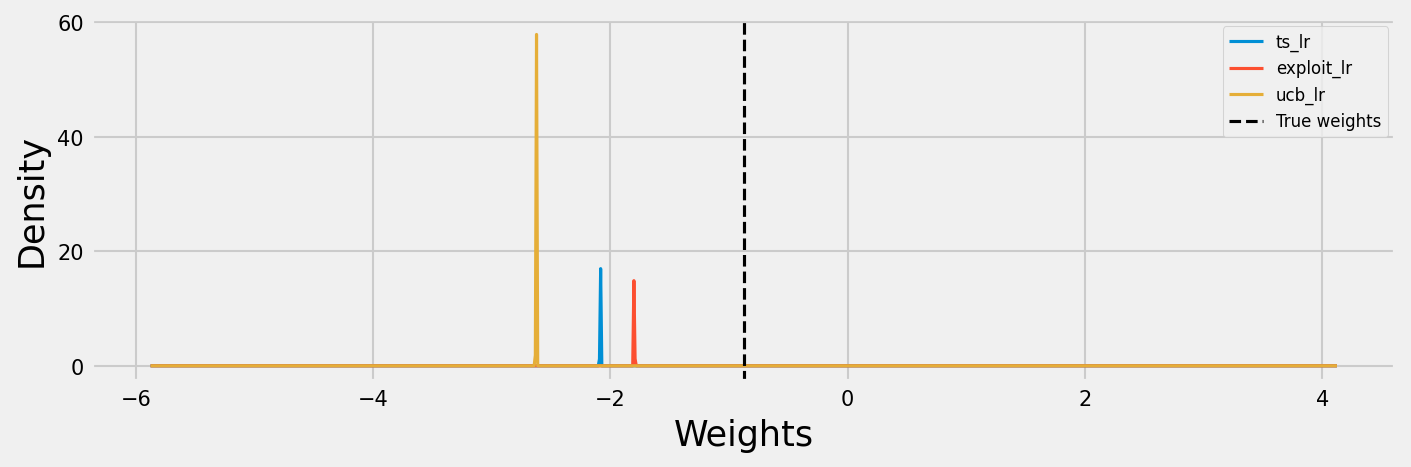

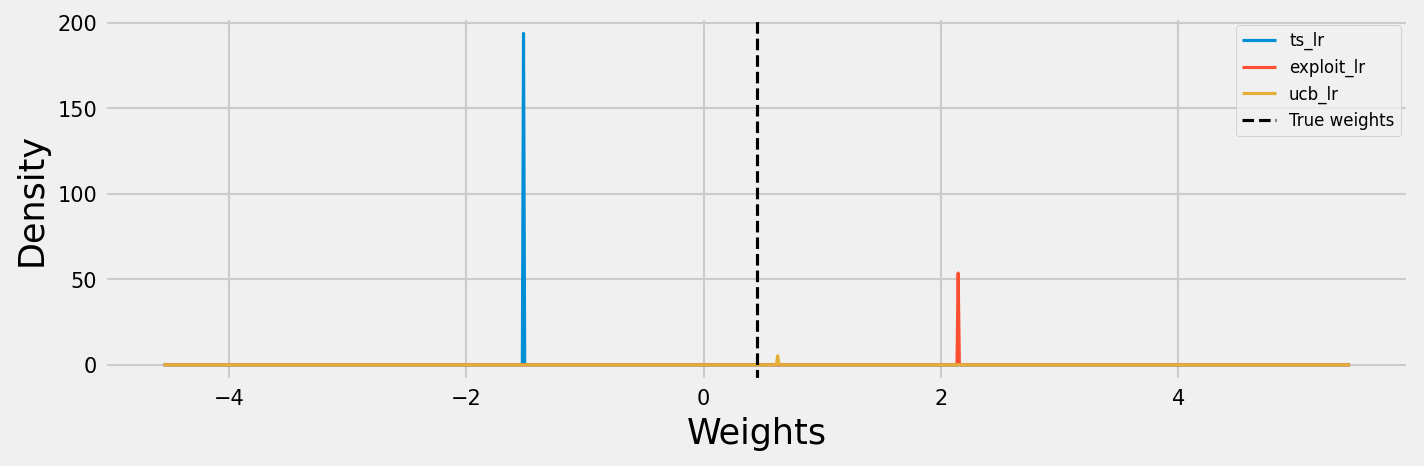

In [126]:
# plot the mean and std of the weights
plt.close('all')
plt.figure(figsize=(10, 3), dpi=150)
# get the final true weights
true_weights = experiment_df_last_round['true_weights'].values[0]
for i in range(n_dim):
    plt.figure(figsize=(10, 3), dpi=150)
    m = true_weights[i]
    sigma = 5
    # loop for each decision policy
    for policy in dp_dict.keys():
        X_pdf = np.linspace(m - sigma, m + sigma, 1000)
        online_lr = dp_dict[policy]
        pdf = norm_dist(loc=online_lr.m[i], scale=online_lr.q[i]**(-1.0)).pdf(X_pdf)
        plt.plot(X_pdf, pdf, label=policy, linewidth=1.5)

    # plot a vertical line at the true weights
    plt.axvline(x=m, color='black', linestyle='--', label='True weights', linewidth=1.5)
    plt.xlabel('Weights')
    plt.ylabel('Density') 
    plt.legend(fontsize=8); plt.xticks(fontsize=10); plt.yticks(fontsize=10)   
plt.show()

In [150]:
# analyze when running with just 10 data perRound
# load the results from pickle
n_providers, n_data_point_per_round, n_rounds, n_dim, lambda_, alpha, n_sims, seed = [10,         100,         100,          3,              0.1,        10,          10,         66]

experiment_df = pd.read_pickle(f"../results/experiment_{n_providers}_{n_data_point_per_round}_{n_rounds}_{n_dim}_{lambda_}_{alpha}_{n_sims}_{seed}.pkl")
# our regret calculations
regret_mean = experiment_df.reset_index().groupby(['policy','round'])['regret'].mean()


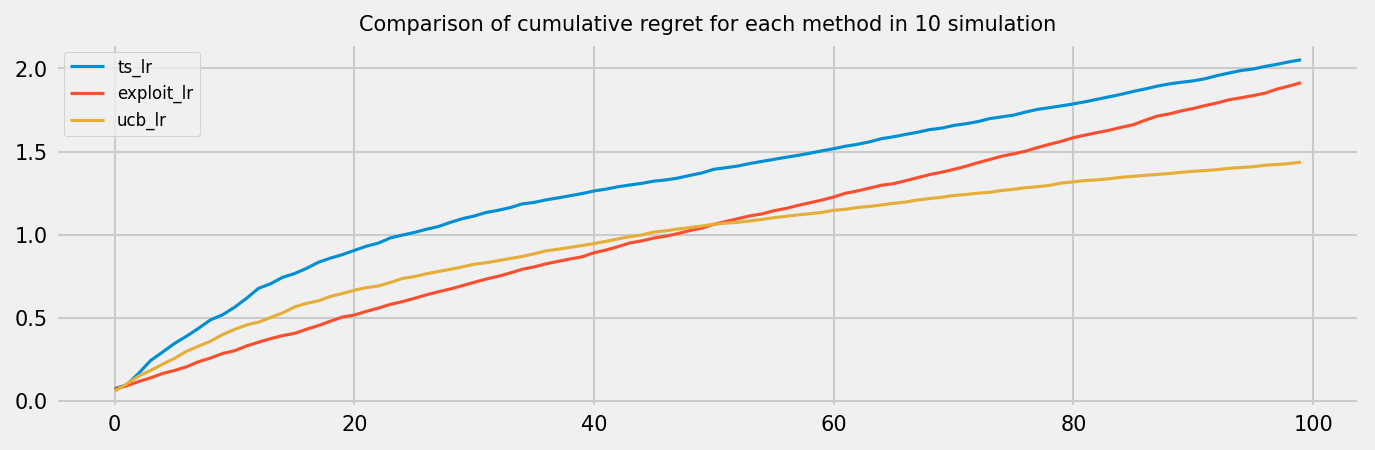

In [143]:
plot_regret(regret_mean, n_sims, regret_type='cumulative')

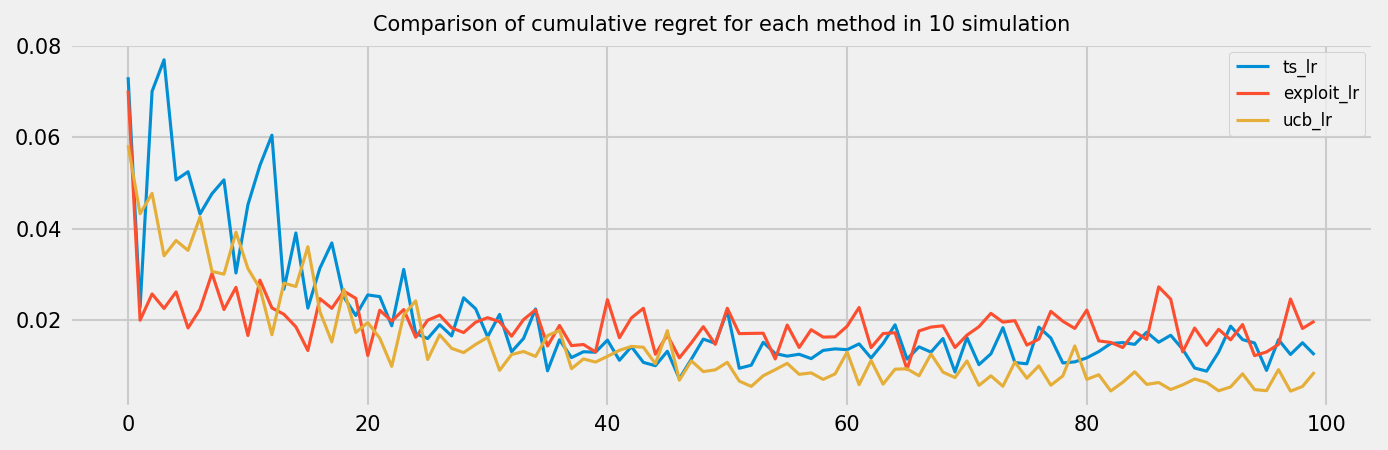

In [145]:
plot_regret(regret_mean, n_sims)

<Figure size 1500x450 with 0 Axes>

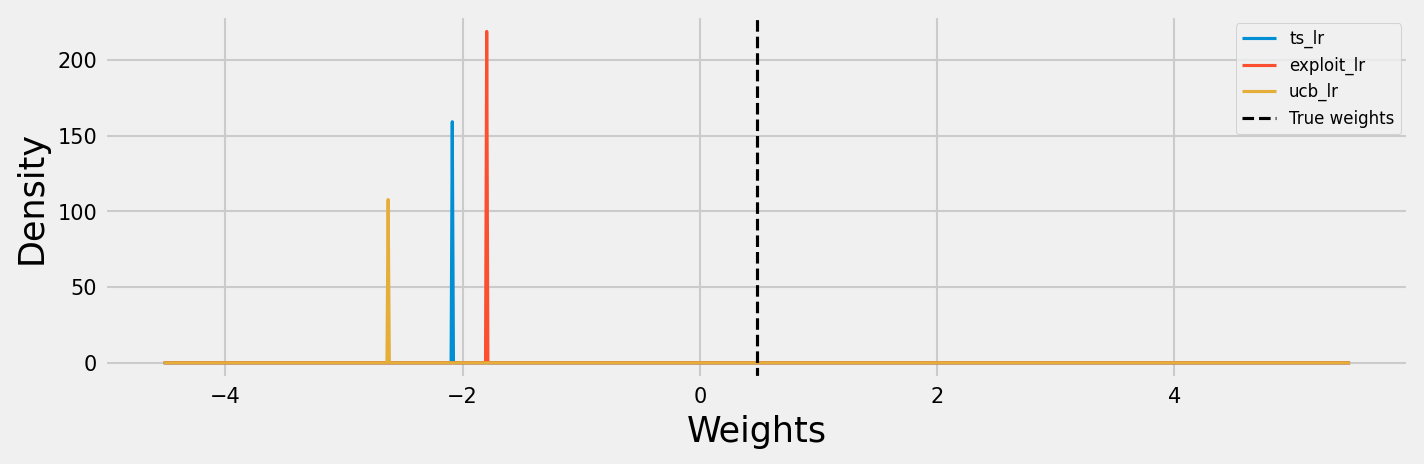

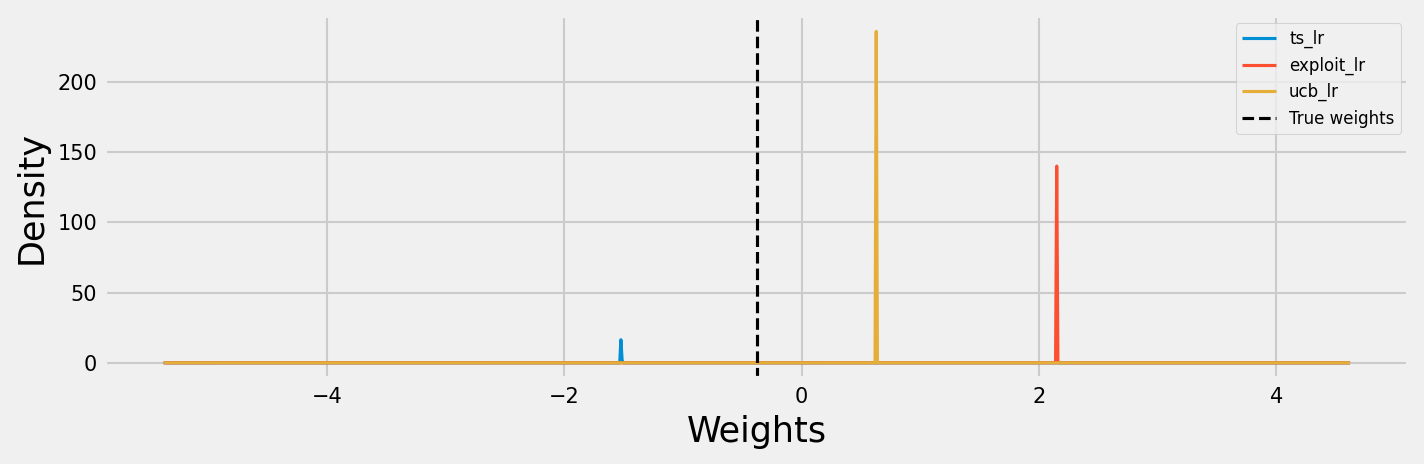

In [147]:
experiment_df_last_round = experiment_df[(experiment_df['round'] == n_rounds - 1) & (experiment_df['simul_id'] == n_sims - 1)]
plot_weight_distribution(experiment_df_last_round)

In [128]:
plot final weights distribution to see if it overlaps.

SyntaxError: expected 'else' after 'if' expression (342037908.py, line 1)

In [ ]:
# try it with multiple parameters:
# parameters:
experiment = 

In [ ]:
plot for 2, 10 features in another notebook

try it with lyra 

simulate new features. 
A system is close to working, get a new feature

